In [1]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from functools import partial
import torch
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler

from src.data_cleaning import clean_tweet
from src.data_preprocessing import yield_tokens, collate_batch
from src.model.model import TweetClassificationModel, evaluate_model, predict
from src.dataset import TweetDataset

In [2]:
# Set seed for reproducibility
seed = 2042
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Load data into pandas DataFrame
df = pd.read_csv("data/cyberbullying_tweets.csv")
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [5]:
# Get info about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [6]:
# Rename feature and label columns
df = df.rename(columns={"tweet_text": "tweet", "cyberbullying_type": "category"})

# Remove duplicates
df = df[~df.duplicated()]

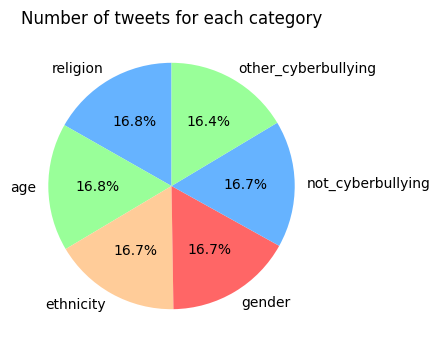

In [7]:
# Check distribution for cyberbullying category
category_counts = df["category"].value_counts()

# Create a pie chart
plt.figure(figsize=(4, 4))
plt.pie(category_counts, labels=category_counts.index, autopct="%1.1f%%", startangle=90, colors=["#66b3ff", "#99ff99", "#ffcc99", "#ff6666"])
plt.title("Number of tweets for each category")
plt.show()

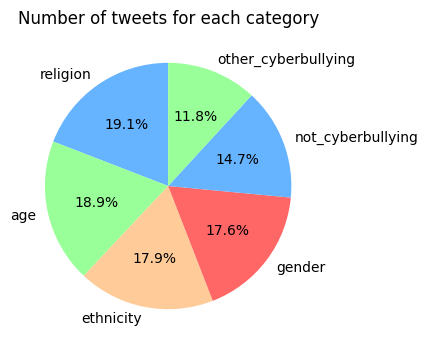

In [8]:
# Clean tweets using functions defined in src, and drop duplicates
# Define stop words for text cleaning
stop_words = set(stopwords.words("english"))
# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

df["clean_tweet"] = [clean_tweet(tweet, lemmatizer, stop_words) for tweet in df["tweet"]]
df.drop_duplicates("clean_tweet", inplace=True)

category_counts = df["category"].value_counts()

# Create a pie chart
plt.figure(figsize=(4, 4))
plt.pie(category_counts, labels=category_counts.index, autopct="%1.1f%%", startangle=90, colors=["#66b3ff", "#99ff99", "#ffcc99", "#ff6666"])
plt.title("Number of tweets for each category")
plt.show()

# After cleaning we can see that category "other_cyberbullying" is reduced to around 12%, because it is too generic
# Remove "other_cyberbullying category" due to its incosistency and being too generic
df = df[df["category"] != "other_cyberbullying"]

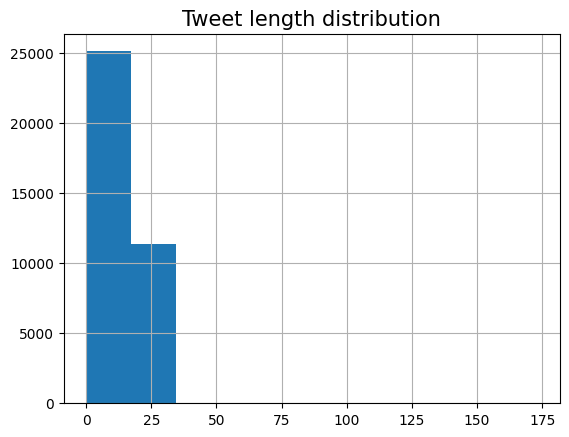

In [9]:
# Add columns for tweet length
df["tweet_length"] = [len(text.split()) for text in df.clean_tweet]
df.sort_values(by=["tweet_length"], ascending=False)

df["tweet_length"].hist()
plt.title("Tweet length distribution", size=15)
plt.show()

In [10]:
# Describe tweet length
print(df["tweet_length"].describe())

count    36503.000000
mean        14.264855
std          7.491224
min          0.000000
25%          8.000000
50%         12.000000
75%         20.000000
max        173.000000
Name: tweet_length, dtype: float64


In [11]:
# Removing outliers - tweets that are too long or too short
df = df[df["tweet_length"] < df["tweet_length"].quantile(0.995)]
df = df[df["tweet_length"] > 0]

In [12]:
# Map each category to numeric value
category_label_mapping = {
    "not_cyberbullying": 0,
    "religion": 1,
    "age": 2,
    "gender": 3,
    "ethnicity": 4,
}

df["category"] = df["category"].map(category_label_mapping)
df.head()

,tweet,category,clean_tweet,tweet_length
0,"In other words #katandandre, your food was cra...",0,word katandandre food crapilicious mkr,5
1,Why is #aussietv so white? #MKR #theblock #ImA...,0,aussietv white mkr theblock imacelebrityau tod...,11
2,@XochitlSuckkks a classy whore? Or more red ve...,0,classy whore red velvet cupcake,5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0,meh thanks head concerned another angry dude t...,8
4,@RudhoeEnglish This is an ISIS account pretend...,0,isi account pretending kurdish account like is...,8


In [13]:
# Split data into Train and Test sets
X = df["clean_tweet"]
y = df["category"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed)

In [14]:
# We need to check if class/category distribution is balanced, if not, we should do oversampling
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 3881],
       [   1, 5017],
       [   2, 4965],
       [   3, 4633],
       [   4, 4709]], dtype=int64)

In [15]:
# Add oversampling to training sets
rand_oversampler = RandomOverSampler()
X_train, y_train = rand_oversampler.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ["clean_tweet", "category"])

X_train = train_os["clean_tweet"].values
y_train = train_os["category"].values

# Check for counts again
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5017],
       [   1, 5017],
       [   2, 5017],
       [   3, 5017],
       [   4, 5017]], dtype=int64)

In [16]:
# Concat validation and test dataframes
train_iter = train_os
test_iter = pd.concat([X_test, y_test], axis=1)
validation_iter = pd.concat([X_valid, y_valid], axis=1)

In [17]:
# Preprocess data and make it ready for model (tokeizing, creating vocabulary, torch dataloader)

tokenizer = get_tokenizer("basic_english")
vocab = build_vocab_from_iterator(yield_tokens(train_iter, tokenizer, "clean_tweet"), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)

# Wrap dataframes with TweetDataset class
train_iter_ds = TweetDataset(train_iter)
test_iter_ds = TweetDataset(test_iter)
validation_iter_ds = TweetDataset(validation_iter)

train_dataset = to_map_style_dataset(train_iter_ds)
test_dataset = to_map_style_dataset(test_iter_ds)
validation_dataset = to_map_style_dataset(validation_iter_ds)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=partial(
        collate_batch,
        device=device,
        label_pipeline=label_pipeline,
        text_pipeline=text_pipeline
    ),
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=partial(
        collate_batch,
        device=device,
        label_pipeline=label_pipeline,
        text_pipeline=text_pipeline
    ),
)

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=partial(
        collate_batch,
        device=device,
        label_pipeline=label_pipeline,
        text_pipeline=text_pipeline
    ),
)


In [18]:
# Create model and train it on training dataset
vocab_size = len(vocab)
num_categories = train_iter["category"].nunique()
embedding_size = 64

model = TweetClassificationModel(vocab_size, embedding_size, num_categories, p_dropout=0.3).to(device)

In [19]:
# Hyperparameters
EPOCHS = 10
LEARN_RATE = 5 # learning rate
MOMENTUM = 0.9
BATCH_SIZE = 32
GAMMA = 0.1

criterion = torch.nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.SGD(model.parameters(), lr=LEARN_RATE, momentum=MOMENTUM) # Optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=GAMMA)
total_accu = None

In [20]:
# Model training and evaluation
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()
    accu_val = evaluate_model(model, validation_dataloader, criterion)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print("-" * 59)
    print(
        "| end of epoch {:3d} | time: {:5.2f}s | "
        "valid accuracy {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, accu_val
        )
    )
    print("-" * 59)

| epoch   1 |   500/ 3136 batches | accuracy    0.800
| epoch   1 |  1000/ 3136 batches | accuracy    0.849
| epoch   1 |  1500/ 3136 batches | accuracy    0.836
| epoch   1 |  2000/ 3136 batches | accuracy    0.869
| epoch   1 |  2500/ 3136 batches | accuracy    0.853
| epoch   1 |  3000/ 3136 batches | accuracy    0.865
-----------------------------------------------------------
| end of epoch   1 | time: 11.23s | valid accuracy    0.873 
-----------------------------------------------------------
| epoch   2 |   500/ 3136 batches | accuracy    0.905
| epoch   2 |  1000/ 3136 batches | accuracy    0.887
| epoch   2 |  1500/ 3136 batches | accuracy    0.900
| epoch   2 |  2000/ 3136 batches | accuracy    0.895
| epoch   2 |  2500/ 3136 batches | accuracy    0.904
| epoch   2 |  3000/ 3136 batches | accuracy    0.896
-----------------------------------------------------------
| end of epoch   2 | time: 11.52s | valid accuracy    0.879 
--------------------------------------------------

In [21]:
# Verify model with test dataset
print("Checking the results of test dataset.")
accu_test = evaluate_model(model, test_dataloader, criterion)
print("test accuracy {:8.3f}".format(accu_test))

Checking the results of test dataset.
test accuracy    0.899


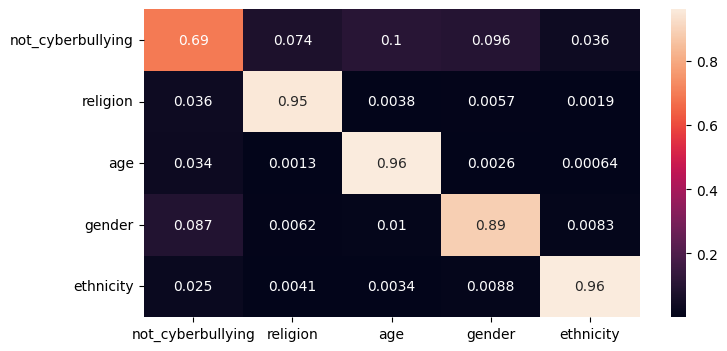

In [22]:
# Create confusion matrix and display it

y_pred = []
y_true = []

for _, (label, text, offsets) in enumerate(test_dataloader):
    predicted_label = model(text, offsets)
    output_label = torch.argmax(predicted_label, dim=1)
    
    for pred_value in output_label:
        y_pred.append(pred_value.item())
    
    for real_value in label:
        y_true.append(real_value.item())

classes = tuple(category_label_mapping.keys())


cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (8,4))
sns.heatmap(df_cm, annot=True)
plt.savefig('conf_matrix.png')
    
    

In [23]:
# Save model
torch.save(model.state_dict(), 'model.pth')

In [24]:
# Load model and make prediction
model.load_state_dict(torch.load('model.pth'))
model = model.to("cpu")

cb_categories = {0: "not_cyberbullying", 1: "religion", 2: "age", 3: "gender", 4: "ethnicity"}

example_tweet = "Hey hey little Christian, you will be dead when Budah's army comes for you, you hear me?!?"
print(f"This tweet goes under '{cb_categories[predict(model, example_tweet, text_pipeline)]}' cyberbullying category.")

This tweet goes under 'religion' cyberbullying category.
